# Fig. 9

In [1]:
# %load /Users/tantanmeow/PycharmProjects/mytoolbox/wave_modes.py
"""
Created on Wed Jul 1 12:09:43 2020

@author: shuwentan-po

This a python code for solving the T-G equation and more. The theory please 
refer to Smyth and Carpenter (2019). This code is largely a re-write of the 
online Matlab code that Smyth has published.

To keep things simple this should only import modules from the python standard
library or numpy and scipy.

Ref: http://salty.oce.orst.edu/wave_analysis/SSF_index.html

"""

%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sig
import scipy.io as io
import scipy.stats as stats
from datetime import datetime, timedelta


class Bunch(object):
    """A class to put all you need to solve eigenmodes in it"""

    def __init__(self,
                 x=None,
                 V=None,
                 D=None,
                 l=None,
                 nu=None,
                 imode=None,
                 sig=None,
                 u=None,
                 v=None,
                 d=None):
        self.x = x
        self.V = V
        self.D = D
        self.l = l
        self.nu = nu
        self.imode = imode
        self.sig = sig
        self.u = u
        self.v = v
        self.d = d


def ddz(z):
    """ First derivative matrix for independent variable z. 2nd order centered 
    differences. Use one-sided derivatives at boundaries. z is assumed to be 
    evenly spaced.

    Parameters
    ----------
    z : 1-D numpy array 

    Returns
    -------
    d : ndarray
        1st derivation matrix

    """
    if np.abs(np.std(np.diff(z)))/np.mean(np.diff(z)) > .000001:
        raise ValueError("ddz: values not evenly spaced!")
        return np.nan
    dz = z[1] - z[0]
    N = len(z)
    d = np.zeros((N, N))
    for i in range(1, N-1, 1):
        d[i, i-1] = -1.
        d[i, i+1] = 1.
    d[0, 0] = -3.
    d[0, 1] = 4.
    d[0, 2] = -1.
    d[-1, -1] = 3.
    d[-1, -2] = -4.
    d[-1, -3] = 1.
    d /= (2*dz)
    return d


def ddz2(z):
    """ Second derivative matrix for independent variable z. 2nd order centered 
    differences. Use one-sided derivatives at boundaries. z is assumed to be 
    evenly spaced.

    Parameters
    ----------
    z : 1-D numpy array 

    Returns
    -------
    d : ndarray
        2st derivation matrix

    """
    if np.abs(np.std(np.diff(z)))/np.mean(np.diff(z)) > .000001:
        raise ValueError("ddz2: values not evenly spaced!")
        return np.nan
    dz = z[1] - z[0]
    N = len(z)
    d = np.zeros((N, N))
    for i in range(1, N-1, 1):
        d[i, i-1] = 1.
        d[i, i] = -2.
        d[i, i+1] = 1.
    d[0, 0] = 2.
    d[0, 1] = -5.
    d[0, 2] = 4.
    d[0, 3] = -1.
    d[-1, -1] = 2.
    d[-1, -2] = -5.
    d[-1, -3] = 4.
    d[-1, -4] = -1.
    d /= dz**2
    return d


def WM_1D(x, V, D, l, nu, imode=1):
    """ 
    Linear wave modes of a hypothetical parallel (y-independent), viscous 
    shallow-water flow. No-flux boundary conditions, varying topography.

    See Pratt et al., 2007 (doi:10.1016/j.ocemod.2007.05.002) for theory.

    Parameters
    ----------
    x : 1-D numpy array 
    V : 1-D numpy array 
        cross-channel background velocity V(x)
    D : 1-D numpy array 
        cross-channel background flow thickness D(x), zero at free edges
    l : float
    nu : ndarray
    imode : mode choice (default imode=1)
            imode=0: output all modes, sorted by growth rate


    Returns
    -------
    sig : ndarray
          growth rate of FGM
    u   : ndarray
          eigenfunction for u
    v   : ndarray
          eigenfunction for v
    d   : ndarray
          eigenfunction for d
    """

    bunch = Bunch(x=x, V=V, D=D, l=l, nu=nu, imode=imode)

    if np.abs(np.std(np.diff(bunch.x)))/np.mean(np.diff(bunch.x)) > .000001:
        raise ValueError("WM_1D: values not evenly spaced!")
        return
    ii = np.array([1j])
    dx = bunch.x[1] - bunch.x[0]
    N = len(bunch.x)
    # The operation matrix
    D1 = ddz(bunch.x)
    Dx = np.dot(D1, bunch.D)
    Vx = np.dot(D1, bunch.V)
    D2 = ddz2(bunch.x)
    Id = np.eye(N)
    N3 = 3*N
    B = np.zeros((N3, N3))
    # for u_hat
    if len(bunch.nu) == 1:
        b11 = -(ii*bunch.l*np.diag(bunch.V)-bunch.nu*D2+bunch.l**2*bunch.nu*Id)
    else:
        a = np.zeros(Id.shape)
        for i in range(len(bunch.nu)):
            a[i, :] = -bunch.nu[i]*D2[i, :]+bunch.l**2*bunch.nu[i]*Id[i, :]
        b11 = -(ii*bunch.l*np.diag(bunch.V)+a)
    b12 = -Id
    b13 = -D1
    # for v_hat
    b21 = -(np.diag(Vx)-Id)
    if len(bunch.nu) == 1:
        b22 = -(ii*bunch.l*np.diag(bunch.V)-bunch.nu*D2+bunch.l**2*bunch.nu*Id)
    else:
        a = np.zeros(Id.shape)
        for i in range(len(bunch.nu)):
            a[i, :] = -bunch.nu[i]*D2[i, :]+bunch.l**2*bunch.nu[i]*Id[i, :]
        b22 = -(ii*bunch.l*np.diag(bunch.V)+a)
    b23 = -ii*bunch.l*Id
    # for d_hat
    b31 = -(np.diag(Dx)+np.dot(np.diag(bunch.D), D1))
    b32 = -ii*bunch.l*np.diag(bunch.D)
    b33 = -ii*bunch.l*np.diag(bunch.V)
    B = np.concatenate((np.concatenate((b11, b12, b13), axis=1), np.concatenate(
        (b21, b22, b23), axis=1), np.concatenate((b31, b32, b33), axis=1)))
    # solve generalized eigenvalue problem
    e, vec = np.linalg.eig(B)
    n = np.argsort(e, kind='mergesort')[::-1]
    e = e[n]
    vec = vec[:, n]
    if bunch.imode == 0:
        sig = e
        u = vec[0:N, :]
        v = vec[N:2*N, :]
        d = vec[2*N::, :]
    else:
        sig = e[bunch.imode-1]
        u = vec[0:N, bunch.imode-1]
        v = vec[N:2*N, bunch.imode-1]
        d = vec[2*N::, bunch.imode-1]
        
    bunch.sig = sig
    bunch.u = u
    bunch.v = v
    bunch.d = d
    return bunch

In [2]:
def find_nearest(array, value):
    """ Find the nearest point of
        code stolen from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


def extract_data(Data):
    """ Extract and regulate data from xarray Dataset. (x, y) - (east, north)"""
    # ragulate data
    t = Data.time.data
    d = Data.H.data
    v = Data.U.data  # northward
    u = Data.V.data  # westward
    h = Data.B.data
    # dims=['time', 'y', 'x']
    # (y, x) is in fact (west, north) convert to (x, y) or (east, north)
    u = -u[:, ::-1, :]  # now the flow speed is toward east
    v = v[:, ::-1, :]
    d = d[:, ::-1, :]
    h = h[::-1, :]
    x = Data.y.data
    y = Data.x.data
    return x, y, t, d, h, v, u


def compute_VD(V, D, H, x, method, x_point):
    from scipy import integrate
    """method = True: Extract data in the channel, then integrate V to obtain D and compute D backward using V
       method = False: Extract data in the channel, where sD>0 
       x_point shows how many points to ignore near edges """
    l = np.where(np.isnan(D))[0]
    dl = np.diff(l)
    ll = np.where(dl > 1)[0][0]
    if method == True:
        idxes_ = np.arange(l[ll]+1+x_point, l[ll+1]-x_point)
        x1_ = x[idxes_]
        H1_ = H[idxes_]
        D1_ = integrate.cumtrapz(-V[idxes_] -
                                 np.dot(ddz(x1_), H[idxes_]), x1_, initial=0)  #+ D[idxes_][0]
        # get rid of points where D1<0
        idxes = np.where(D1_ >= 0)[0]
        D1 = D1_[idxes]
        x1 = x1_[idxes]
        H1 = H1_[idxes]
        V1 = -np.dot(ddz(x1), H1) - np.dot(ddz(x1), D1)
    else:
        idxes_ = np.arange(l[ll]+1+x_point, l[ll+1]-x_point)
        D1 = D[idxes_]
        x1 = x[idxes_]
        H1 = H[idxes_]
        V1 = -np.dot(ddz(x1), H1) - np.dot(ddz(x1), D1)

    return V1, D1, x1, H1


def count_zero_crossings(v):
    """Count how many zero-crossings on 1d or 2d (m,n) array v, m is the profile, n is number of profile
    ; I - int
    https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python"""
    if len(v.shape) == 2:
        I = np.zeros((len(v[0, :])))
        for i in range(len(v[0, :])): 
            I[i] = len(np.where(np.diff(np.signbit(v[:,i])))[0])
    if len(v.shape) == 1:
        I = len(np.where(np.diff(np.signbit(v)))[0])
    return I

In [11]:
def mode_along_channel(V, D, H, x, y, l0, nu, imode, method, Nx, x_channel_range, x_point, offset = 5e-2):
    """Compute wave modes and sort according to phase speeds along the channel"""
    from scipy.interpolate import interp1d
    count = 50
    # real and imaginary part of wave speeds
    c_r = np.zeros((len(y), count)) + np.nan
    c_i = np.zeros((len(y), count)) + np.nan
    # mode for v & d
    v_hat = np.zeros((x_channel_range, len(y), count)) + np.nan
    d_hat = np.zeros((x_channel_range, len(y), count)) + np.nan
    # numbers of zero-crossings
    N_zero = np.zeros((len(y), count)) + np.nan
    # background properties
    V_m = np.zeros((x_channel_range, len(y))) + np.nan
    D_m = np.zeros((x_channel_range, len(y))) + np.nan
    X_m = x[0:x_channel_range]

    for i in range(len(y)):
        D0 = D[:,i]
        D0[D0 < 1e-7] = np.nan
        V1, D1, x1, _ = compute_VD(V[:,i], D0, H[:,i], x, method, x_point)
        x1__ = x1.copy()
        _, idx_xs = find_nearest(x[0:x_channel_range], x1[0])
        _, idx_xe = find_nearest(x[0:x_channel_range], x1[-1])
        V_m[idx_xs:idx_xe+1, i] = V1
        D_m[idx_xs:idx_xe+1, i] = D1  
        
        # interpolate v, d onto finer grids
        if Nx > 0:
#             x1_ = np.arange(x1[0],x1[-1]+1e-4,dx)
            x1_ = np.linspace(x1[0], x1[-1], Nx)
            f = interp1d(x1, V1, bounds_error=False, kind='cubic', fill_value='extrapolate')
            V1_ = f(x1_)
            f = interp1d(x1, D1, bounds_error=False, kind='cubic', fill_value='extrapolate')
            D1_ = f(x1_)
            x1 = x1_.copy()
            V1 = V1_.copy()
            D1 = D1_.copy()

        data = WM_1D(x1, V1, D1, l0, np.array([nu]), imode)
        # Convert growth rates to phase speeds
        cphs = np.zeros(data.sig.shape)
        inst = np.zeros(data.sig.shape)
        cphs = -np.imag(data.sig)/l0
        inst = np.real(data.sig)/l0

        # sort by phase speed, fastest first
        n = np.argsort(cphs, kind='mergesort')[::-1]
        cphs = cphs[n]
        inst = inst[n]
        u = data.u[:, n]
        v = data.v[:, n]
        d = data.d[:, n]

        del data
        # normalize using the amplitude of v as a reference
        u /= np.max(np.abs(u), axis=0)
        v /= np.max(np.abs(v), axis=0)
        d /= np.max(np.abs(d), axis=0)   
        # compute zero crossings of V profiles, add a small offset so that large anomalous
        # zero-crossings due to small wiggles near zero are eliminated  
        zero_crossings = count_zero_crossings(np.real(v+np.sign(v.mean(axis=0))*offset))
        # pick out modes 
        l = np.where((np.abs(cphs)<1e+1)&(zero_crossings<4)&(np.abs(inst)<1e+2))[0]
        if len(l) > 0:
            c_r[i, 0:len(l)] = cphs[l]
            c_i[i, 0:len(l)] = inst[l] 
            N_zero[i, 0:len(l)] = zero_crossings[l]
            a, idx_xs = find_nearest(x[0:x_channel_range], x1[0])
            a, idx_xe = find_nearest(x[0:x_channel_range], x1[-1])
            for ii in range(len(l)):
                f = interp1d(x1, np.real(v[:, l[ii]]), bounds_error=False, kind='linear', fill_value='nan')
                v_hat[idx_xs:idx_xe+1, i, ii] = f(x1__)
                f = interp1d(x1, np.real(d[:, l[ii]]), bounds_error=False, kind='linear', fill_value='nan')
                d_hat[idx_xs:idx_xe+1, i, ii] = f(x1__)
            
    return c_r, c_i, v_hat, d_hat, N_zero, V_m, D_m, X_m


In [12]:
def mode_data(Data, y_s, y_e, t_s, t_e, l0, nu, imode, method, Nx, x_channel_range, x_point=2):
    """Compute wave modes and sort according to phase speeds along the channel"""
    count = 50
    x, y, t, d, h, v, _  = extract_data(Data)
    a, idx_ys = find_nearest(y, y_s)
    a, idx_ye = find_nearest(y, y_e)
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    # compute the time-mean (background flow properties)
    vm = np.squeeze(np.mean(v[idx_ts:idx_te, :, idx_ys:idx_ye], axis=0))
    dm = np.squeeze(np.mean(d[idx_ts:idx_te, :, idx_ys:idx_ye], axis=0))
    h = h[:, idx_ys:idx_ye]

    c_r, c_i, v_hat, d_hat, N_zero, V_m, D_m, X_m = mode_along_channel(
        vm, dm, h, x, y[idx_ys:idx_ye], l0, nu, imode, method, Nx, x_channel_range, x_point)

    # numpy.array to xarray.DataArray
    C_r = xr.DataArray(c_r, [('y', y[idx_ys:idx_ye]),
                                       ('modes', np.arange(count))])
    C_i = xr.DataArray(c_i, [('y', y[idx_ys:idx_ye]),
                                       ('modes', np.arange(count))])
    V_hat = xr.DataArray(v_hat, [('x', X_m),
                                   ('y', y[idx_ys:idx_ye]),
                                   ('modes', np.arange(count))])
    D_hat = xr.DataArray(d_hat, [('x', X_m),
                                     ('y', y[idx_ys:idx_ye]),
                                     ('modes', np.arange(count))])
    N_zero = xr.DataArray(N_zero, [('y', y[idx_ys:idx_ye]),
                                   ('modes', np.arange(count))])
    V_M = xr.DataArray(V_m, [('x', X_m),
                             ('y', y[idx_ys:idx_ye])])
    D_M = xr.DataArray(D_m, [('x', X_m),
                             ('y', y[idx_ys:idx_ye])])

    # build Dataset
    Data_mode = xr.Dataset({'C_r': (['y', 'modes'], C_r),
                            'C_i': (['y', 'modes'], C_i),
                            'V_hat': (['x', 'y', 'modes'], V_hat),
                            'D_hat': (['x', 'y', 'modes'], D_hat),
                            'N_zero': (['y', 'modes'], N_zero),
                            'V_M': (['x', 'y'], V_M),
                            'D_M': (['x', 'y'], D_M)},
                           coords={'x': X_m,
                                   'y': y[idx_ys:idx_ye],
                                   'modes': np.arange(count)},
                           attrs={'title': 'Eigen mode solutions',
                                  'description': 'Parallel flow, long wave, small viscosity'})
    return Data_mode

In [13]:
def plot_modes(Data, y_s, y_e, t_s, t_e, l0, nu, imode, method, dy, Nx, outpath, x_channel_range, offset = .05, x_point=2):
    """Compute wave modes and sort according to phase speeds along the channel
       plot selected modes so I can later group modes by eye"""
    from scipy.interpolate import interp1d
    x, y, t, d, h, v, _  = extract_data(Data)
    a, idx_ys = find_nearest(y, y_s)
    a, idx_ye = find_nearest(y, y_e)
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    # compute the time-mean (background flow properties)
    vm = np.squeeze(np.mean(v[idx_ts:idx_te, :, idx_ys:idx_ye], axis=0))
    dm = np.squeeze(np.mean(d[idx_ts:idx_te, :, idx_ys:idx_ye], axis=0))
    h = h[:, idx_ys:idx_ye]
    
    for i in np.arange(0, len(y[idx_ys:idx_ye]), dy):
        D0 = dm[:,i]
        D0[D0 < 1e-7] = np.nan
        V1, D1, x1, _ = compute_VD(vm[:,i], D0, h[:,i], x, method, x_point)
        
        # interpolate v, d onto finer grids
        if Nx > 0:
#             x1_ = np.arange(x1[0],x1[-1]+1e-4,dx)
            x1_ = np.linspace(x1[0], x1[-1], Nx)
            f = interp1d(x1, V1, bounds_error=False, kind='cubic', fill_value='extrapolate')
            V1_ = f(x1_)
            f = interp1d(x1, D1, bounds_error=False, kind='cubic', fill_value='extrapolate')
            D1_ = f(x1_)
            x1 = x1_.copy()
            V1 = V1_.copy()
            D1 = D1_.copy()

        data = WM_1D(x1, V1, D1, l0, np.array([nu]), imode)
        # Convert growth rates to phase speeds
        cphs = np.zeros(data.sig.shape)
        inst = np.zeros(data.sig.shape)
        cphs = -np.imag(data.sig)/l0
        inst = np.real(data.sig)/l0

        # sort by phase speed, fastest first
        n = np.argsort(cphs, kind='mergesort')[::-1]
        cphs = cphs[n]
        inst = inst[n]
        u = data.u[:, n]
        v = data.v[:, n]
        d = data.d[:, n]

        del data
        # normalize using the amplitude of v as a reference
        u /= np.max(np.abs(v), axis=0)
        v /= np.max(np.abs(v), axis=0)
        d /= np.max(np.abs(v), axis=0)   
        # compute zero crossings of V profiles, add a small offset so that large anomalous
        # zero-crossings due to small wiggles near zero are eliminated  
        zero_crossings = count_zero_crossings(np.real(v+np.sign(v.mean(axis=0))*offset))
        l = np.where((np.abs(cphs)<1e+1)&(zero_crossings<4)&(np.abs(inst)<1e+2))[0]
        
        fig = plt.figure(figsize=(20,4))
        ax = fig.add_subplot(131)
        for ii in range(len(l)):
            ax.plot(x1, v[:, l[ii]], label=round(cphs[l][ii], 2))
        ax.legend()
        ax.set_title('v hat, label = c_r')
        ax = fig.add_subplot(132)
        for ii in range(len(l)):
            ax.plot(x1, d[:, l[ii]], label=round(zero_crossings[l][ii], 2))
        ax.legend()
        ax.set_title('d hat, label = No. of zero crossing')
        ax = fig.add_subplot(133)
        ax.plot(x, vm[:,i], c='k')
        for iii in range(len(l)):
            ax.plot(x1, V1, label=round(inst[l][ii], 2))
        ax.legend()
        ax.set_xlim([0,10])
        ax.set_title('V, y = '+str(np.round(y[idx_ys:idx_ye][i],2))+' label = c_i')
        
        plt.savefig(outpath+'Fig'+str(i)+'.png', dpi=300)

### step1: plot all modes that have zero crossings < 4
contact S.Tan for model output

In [14]:
## MAIN PROGRAM ##

# wavenumber; viscosity; mode numbers
import xarray as xr
l0 = 1e-6
imode = 0
# average time period
t_s = 100
t_e = 800
# space range
y_s = 30
y_e = 40
# how many modes to keep
count = 3
# compute the integrated mean V using points where D>0 (True) or mean V and D at points where D>0 (False)
method = True

model_path = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'
dy = 5
offset = .05
Nx = 150
nu = 1e-7
x_point = 2

In [15]:
x_channel_range = 60
Data = xr.open_dataset(model_path + 'Data_2.nc')
Mode_n = mode_data(Data, y_s, y_e, t_s, t_e, l0, nu, imode, method, Nx, x_channel_range, x_point)

x_channel_range = 60
Data = xr.open_dataset(model_path + 'Data_1.nc')
Mode_fsp = mode_data(Data, y_s, y_e, t_s, t_e, l0, nu, imode, method, Nx, x_channel_range, x_point)

x_channel_range = 60
Data = xr.open_dataset(model_path + 'Data_11.nc')
Mode_nfsp = mode_data(Data, y_s, y_e, t_s, t_e, l0, nu, imode, method, Nx, x_channel_range, x_point)


## Fig. 9

In [16]:
def plot_c(Mode_, dy, ax, method = True):
    for i in np.arange(0, len(Mode_.y), dy):
        cr = Mode_.C_r[i, :].data
        vmax = Mode_.V_M[:, i].max().data
        vmin = Mode_.V_M[:, i].min().data
        idx0 = idx_0(Mode_, i, method)
        
        if len(idx0)>0:
            for j in range(len(idx0)):
                if (np.abs(cr[idx0[j]]) > vmin) & (np.abs(cr[idx0[j]]) > vmax):
                    ax.plot(cr[idx0[j]].copy()*0 + Mode_.y.data[i], cr[idx0[j]], '.', c='k', ms=14)
                else:
                    ax.plot(cr[idx0[j]].copy()*0 + Mode_.y.data[i], cr[idx0[j]], '.', c='k', ms=14)


In [17]:
def idx_0(Mode_, i, method = True):
    '''method = True: seek for the fasest growing modes which are also frontal waves
    method = False: seek for the fastest growing modes (regardless structure)'''
    cr = Mode_.C_r[i, :]
    n0 = Mode_.N_zero[i, :]
    n0_nooffset = n0.copy()
    vmax = Mode_.V_M[:, i].max().data
    vmin = Mode_.V_M[:, i].min().data
    v_diff = np.zeros(len(Mode_.modes)) + np.nan
    v_diff_lr = np.zeros(len(Mode_.modes)) + np.nan
    for j in range(len(Mode_.modes)):
        v = Mode_.V_hat[:,i,j][~np.isnan(Mode_.V_hat[:,i,j])].data
        if len(v)>1:
            n0_nooffset[j] = count_zero_crossings(v)
            v_diff[j] = np.abs(v.max()-v.min())
            v_diff_lr[j] = np.abs(v[-1]-v[0])
    idx0 = np.where((n0 == 0) & (v_diff_lr > v_diff/2))[0]

    if not method:
        if len(idx0) > 2: 
            idx0 = np.array([idx0[0], idx0[-1]])
        
    return idx0

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages

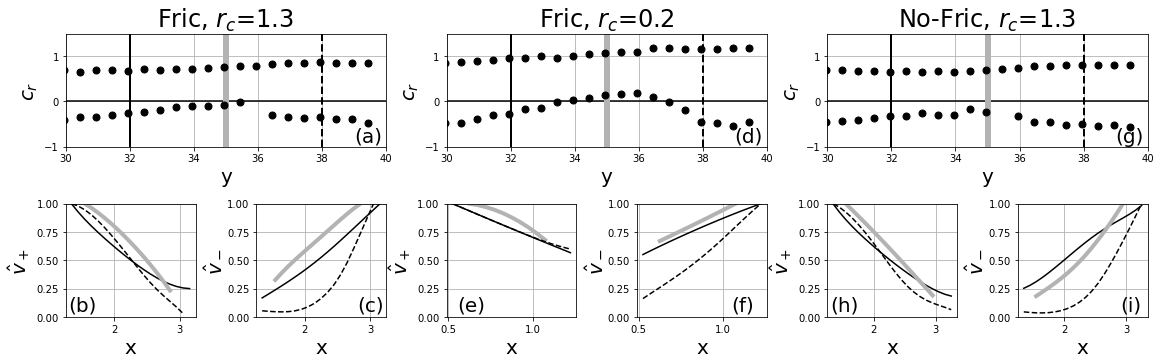

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(2, 6)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 0:2])
ax4 = plt.subplot(gs[-1, 0])
ax5 = plt.subplot(gs[-1, 1])

# ax6 = plt.subplot(gs[0, 2])
# ax7 = plt.subplot(gs[0, 3])
ax8 = plt.subplot(gs[0, 2:4])
ax9 = plt.subplot(gs[-1, 2])
ax10 = plt.subplot(gs[-1, 3])

# ax11 = plt.subplot(gs[0, 4])
# ax12 = plt.subplot(gs[0, -1])
ax13 = plt.subplot(gs[0, 4::])
ax14 = plt.subplot(gs[-1, 4])
ax15 = plt.subplot(gs[-1, -1])

matplotlib.rcParams.update({'font.size': 12})

ax3.plot([30, 40], [0, 0], color='k')
ax3.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax3.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax3.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_fsp, dy, ax3, False)
ax3.set_ylim((-1, 1.5))
ax3.set_xlim((30, 40))
ax3.set_ylabel('$c_r$', fontsize = 20)
ax3.set_xlabel('y', fontsize = 20)
ax3.set_title('Fric, '+'$r_c$=1.3', fontsize = 24)
ax3.text(39, -.9, '(a)', fontsize=20, color='black')
ax3.grid(True)

i = 20
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.V_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, -Mode_fsp.V_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.V_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, Mode_fsp.V_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.V_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, Mode_fsp.V_hat[:, i, j], c='k', linestyle='--')
ax4.set_ylim((0, 1))
ax4.set_ylabel('$\hat{v}_+$', fontsize = 20)
ax4.set_xlabel('x', fontsize = 20)
ax4.set_title(' ')
ax4.text(1.3, .05, '(b)', fontsize=20, color='black')
ax4.grid(True)
ax5.set_ylim((0, 1))
ax5.set_ylabel('$\hat{v}_-$', fontsize = 20)
ax5.set_xlabel('x', fontsize = 20)
ax5.set_title(' ')
ax5.text(2.8, .05, '(c)', fontsize=20, color='black')
ax5.grid(True)

ax8.plot([30, 40], [0, 0], color='k')
ax8.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax8.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax8.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_n, dy, ax8, False)
ax8.set_ylim((-1, 1.5))
ax8.set_xlim((30, 40))
ax8.set_ylabel('$c_r$', fontsize = 20)
ax8.set_xlabel('y', fontsize = 20)
ax8.set_title('Fric, '+'$r_c$=0.2', fontsize = 24)
ax8.text(39, -.9, '(d)', fontsize=20, color='black')
ax8.grid(True)

i = 20
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.V_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax10.plot(Mode_n.x, Mode_n.V_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.V_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax10.plot(Mode_n.x, Mode_n.V_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.V_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax10.plot(Mode_n.x, Mode_n.V_hat[:, i, j], c='k', linestyle='--')
ax9.set_ylim((0, 1))
ax9.set_ylabel('$\hat{v}_+$', fontsize = 20)
ax9.set_xlabel('x', fontsize = 20)
ax9.set_title(' ')
ax9.text(.55, .05, '(e)', fontsize=20, color='black')
ax9.grid(True)
ax10.set_ylim((0, 1))
ax10.set_ylabel('$\hat{v}_-$', fontsize = 20)
ax10.set_xlabel('x', fontsize = 20)
ax10.set_title(' ')
ax10.text(1.05, .05, '(f)', fontsize=20, color='black')
ax10.grid(True)

ax13.plot([30, 40], [0, 0], color='k')
ax13.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax13.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax13.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_nfsp, dy, ax13, False)
ax13.set_ylim((-1, 1.5))
ax13.set_xlim((30, 40))
ax13.set_ylabel('$c_r$', fontsize = 20)
ax13.set_xlabel('y', fontsize = 20)
ax13.set_title('No-Fric, '+'$r_c$=1.3', fontsize = 24)
ax13.text(39, -.9, '(g)', fontsize=20, color='black')
ax13.grid(True)

i = 20
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.V_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, -Mode_nfsp.V_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.V_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, Mode_nfsp.V_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.V_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, Mode_nfsp.V_hat[:, i, j], c='k', linestyle='--')
ax14.set_ylim((0, 1))
ax14.set_ylabel('$\hat{v}_+$', fontsize = 20)
ax14.set_xlabel('x', fontsize = 20)
ax14.set_title(' ')
ax14.text(1.3, .05, '(h)', fontsize=20, color='black')
ax14.grid(True)
ax15.set_ylim((0, 1))
ax15.set_ylabel('$\hat{v}_-$', fontsize = 20)
ax15.set_xlabel('x', fontsize = 20)
ax15.set_title(' ')
ax15.text(2.9, .05, '(i)', fontsize=20, color='black')
ax15.grid(True)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0, h_pad=0)
plt.savefig('../pics/Fig9.eps')

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages

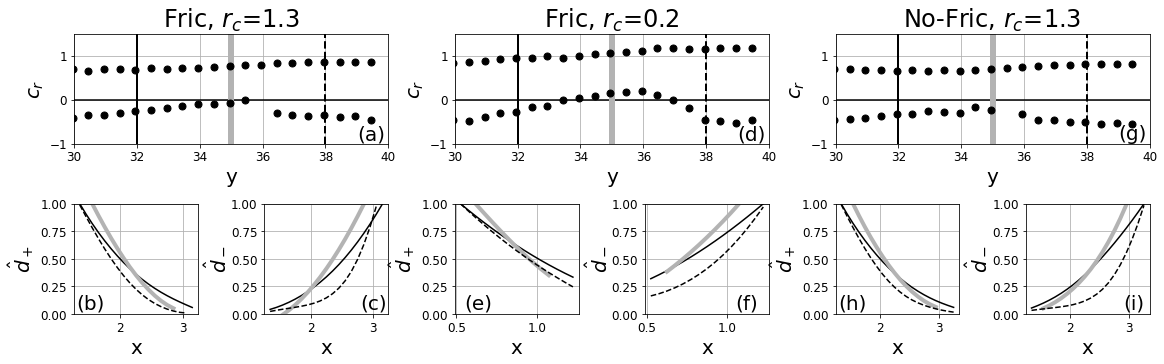

In [21]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(2, 6)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 0:2])
ax4 = plt.subplot(gs[-1, 0])
ax5 = plt.subplot(gs[-1, 1])

# ax6 = plt.subplot(gs[0, 2])
# ax7 = plt.subplot(gs[0, 3])
ax8 = plt.subplot(gs[0, 2:4])
ax9 = plt.subplot(gs[-1, 2])
ax10 = plt.subplot(gs[-1, 3])

# ax11 = plt.subplot(gs[0, 4])
# ax12 = plt.subplot(gs[0, -1])
ax13 = plt.subplot(gs[0, 4::])
ax14 = plt.subplot(gs[-1, 4])
ax15 = plt.subplot(gs[-1, -1])

matplotlib.rcParams.update({'font.size': 12})

ax3.plot([30, 40], [0, 0], color='k')
ax3.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax3.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax3.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_fsp, dy, ax3, False)
ax3.set_ylim((-1, 1.5))
ax3.set_xlim((30, 40))
ax3.set_ylabel('$c_r$', fontsize = 20)
ax3.set_xlabel('y', fontsize = 20)
ax3.set_title('Fric, '+'$r_c$=1.3', fontsize = 24)
ax3.text(39, -.9, '(a)', fontsize=20, color='black')
ax3.grid(True)

i = 20
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.D_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, Mode_fsp.D_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.D_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, -Mode_fsp.D_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_fsp, i, False)
ax4.plot(Mode_fsp.x, Mode_fsp.D_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax5.plot(Mode_fsp.x, -Mode_fsp.D_hat[:, i, j], c='k', linestyle='--')
ax4.set_ylim((0, 1))
ax4.set_ylabel('$\hat{d}_+$', fontsize = 20)
ax4.set_xlabel('x', fontsize = 20)
ax4.set_title(' ')
ax4.text(1.3, .05, '(b)', fontsize=20, color='black')
ax4.grid(True)
ax5.set_ylim((0, 1))
ax5.set_ylabel('$\hat{d}_-$', fontsize = 20)
ax5.set_xlabel('x', fontsize = 20)
ax5.set_title(' ')
ax5.text(2.8, .05, '(c)', fontsize=20, color='black')
ax5.grid(True)

ax8.plot([30, 40], [0, 0], color='k')
ax8.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax8.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax8.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_n, dy, ax8, False)
ax8.set_ylim((-1, 1.5))
ax8.set_xlim((30, 40))
ax8.set_ylabel('$c_r$', fontsize = 20)
ax8.set_xlabel('y', fontsize = 20)
ax8.set_title('Fric, '+'$r_c$=0.2', fontsize = 24)
ax8.text(39, -.9, '(d)', fontsize=20, color='black')
ax8.grid(True)

i = 20
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.D_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax10.plot(Mode_n.x, -Mode_n.D_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.D_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax10.plot(Mode_n.x, -Mode_n.D_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_n, i, False)
ax9.plot(Mode_n.x, Mode_n.D_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax10.plot(Mode_n.x, -Mode_n.D_hat[:, i, j], c='k', linestyle='--')
ax9.set_ylim((0, 1))
ax9.set_ylabel('$\hat{d}_+$', fontsize = 20)
ax9.set_xlabel('x', fontsize = 20)
ax9.set_title(' ')
ax9.text(.55, .05, '(e)', fontsize=20, color='black')
ax9.grid(True)
ax10.set_ylim((0, 1))
ax10.set_ylabel('$\hat{d}_-$', fontsize = 20)
ax10.set_xlabel('x', fontsize = 20)
ax10.set_title(' ')
ax10.text(1.05, .05, '(f)', fontsize=20, color='black')
ax10.grid(True)

ax13.plot([30, 40], [0, 0], color='k')
ax13.plot([35, 35], [-1, 1.5], color='0.7', lw=6)
ax13.plot([32, 32], [-1, 1.5], color='k', lw=2)
ax13.plot([38, 38], [-1, 1.5], color='k', linestyle='--', lw=2)
plot_c(Mode_nfsp, dy, ax13, False)
ax13.set_ylim((-1, 1.5))
ax13.set_xlim((30, 40))
ax13.set_ylabel('$c_r$', fontsize = 20)
ax13.set_xlabel('y', fontsize = 20)
ax13.set_title('No-Fric, '+'$r_c$=1.3', fontsize = 24)
ax13.text(39, -.9, '(g)', fontsize=20, color='black')
ax13.grid(True)

i = 20
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.D_hat[:, i, idx0[0]], c='k')
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, Mode_nfsp.D_hat[:, i, j], c='k')
i = 50
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.D_hat[:, i, idx0[0]], c='.7', lw=4)
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, -Mode_nfsp.D_hat[:, i, j], c='.7', lw=4)
i = 80
idx0 = idx_0(Mode_nfsp, i, False)
ax14.plot(Mode_nfsp.x, Mode_nfsp.D_hat[:, i, idx0[0]], c='k', linestyle='--')
for j in idx0[1::]:
    ax15.plot(Mode_nfsp.x, -Mode_nfsp.D_hat[:, i, j], c='k', linestyle='--')
ax14.set_ylim((0, 1))
ax14.set_ylabel('$\hat{d}_+$', fontsize = 20)
ax14.set_xlabel('x', fontsize = 20)
ax14.set_title(' ')
ax14.text(1.3, .05, '(h)', fontsize=20, color='black')
ax14.grid(True)
ax15.set_ylim((0, 1))
ax15.set_ylabel('$\hat{d}_-$', fontsize = 20)
ax15.set_xlabel('x', fontsize = 20)
ax15.set_title(' ')
ax15.text(2.9, .05, '(i)', fontsize=20, color='black')
ax15.grid(True)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0, h_pad=0)
# plt.savefig('../pics/Fig9_d.eps')